# Xây dựng Chatbot sử dụng mô hình Transformer

In [1]:
import pandas as pd
import numpy as np
import re,string
from gensim.models import KeyedVectors
from collections import Counter
from underthesea import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras import preprocessing, utils, activations
# from keras.callbacks import ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')

2023-10-08 07:21:39.429500: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-08 07:21:39.429548: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-08 07:21:39.429572: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-08 07:21:39.437086: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
!python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

2023-10-08 07:21:41.236204: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-08 07:21:41.236257: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-08 07:21:41.236281: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-08 07:21:41.242826: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[PhysicalDevice(name='/physical_device:GPU:0', dev

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.14.0


In [10]:
df = pd.read_csv('/home/dattran/datadrive/AI-project/vietnamese_chatbot_research/input/vietnamese-chatbot/d liu chatbot question-answer short style.csv')
df.head()

,Unnamed: 0,user_a,user_b
0,0,Thích mẫu người nào,"Dễ thương, tóc dài, da trắng"
1,1,Có crush ai không,Có 1 bạn cùng lớp
2,2,Tại sao lại thích bạn dó,Vì đáp ứng những yêu cầu của tao
3,3,Có hay nói chuyện không,Hay nhắn tin messenger
4,4,Bạn kia có bắt chuyện trước không,Có đôi khi


In [11]:
df.shape

(5900, 3)

**Text Cleaning / Preprocessing**

In [12]:
df.isna().sum()

Unnamed: 0    0
user_a        0
user_b        1
dtype: int64

In [13]:
idx = df[df['user_b'].isnull()].index.tolist() # Get index of nan row
print('Question of nan answer: ' ,df['user_a'][idx].values)

Question of nan answer:  ['Anh chị em làm gì?']


In [14]:
# Fill in nan row value
df['user_b'] = df['user_b'].fillna('Luật sư').values 

In [15]:
# Preprocessing
EMOTICONS = { 
    u":-3":"Happy face smiley",
    u":3":"Happy face smiley",
    u":->":"Happy face smiley",
    u":>":"Happy face smiley",
    u":))":"Happy face smiley",
    u":)))":"Happy face smiley",
    u":))))":"Happy face smiley",
    u":'<":"Happy face smiley",
    u":)":"Happy face smiley",
    u":(":"Happy face smiley",
    u":((":"Happy face smiley",
    u":‑D":"Laughing, big grin or laugh with glasses",
    u":D":"Laughing, big grin or laugh with glasses",
    u"XD":"Laughing, big grin or laugh with glasses",
    u"=D":"Laughing, big grin or laugh with glasses",
    u":‑c":"Frown, sad, andry or pouting",
    u":c":"Frown, sad, andry or pouting",
    u":‑<":"Frown, sad, andry or pouting",
    u":<":"Frown, sad, andry or pouting",
    u":@":"Frown, sad, andry or pouting",
    u"D:":"Sadness",
    u":O":"Surprise",
    u":o":"Surprise",
}

cnt = Counter()
for text in df["user_b"].values:
    for word in text.split():
        cnt[word] += 1

RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-10-1:-1]]) #Get top 10 rare word

def remove_emoticons(text):
    "Function to remove emoticons"
    arr = [word for word in text.split() if word not in EMOTICONS.keys()]
    return " ".join(arr)

def remove_rarewords(text):
    """custom function to remove the rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

def preprocessing(df): 
  df["user_a"] = df["user_a"].apply(lambda ele: ele.translate(str.maketrans('', '', string.punctuation))) # Remove punctuation
  df["user_b"] = df["user_b"].apply(lambda ele: ele.translate(str.maketrans('', '', string.punctuation))) 
  df["user_a"] = df["user_a"].apply(lambda ele: remove_emoticons(ele)) # Remove emoticons
  df["user_b"] = df["user_b"].apply(lambda ele: remove_emoticons(ele))
  df["user_a"] = df["user_a"].apply(lambda ele: remove_rarewords(ele)) # Remove rarewords
  df["user_b"] = df["user_b"].apply(lambda ele: remove_rarewords(ele))
  df['user_b'] = df['user_b'].apply(lambda ele: 'START ' + ele + ' END')
  df["user_a"] = df["user_a"].apply(lambda ele: ele.lower()) # convert text to lowercase
  df["user_b"] = df["user_b"].apply(lambda ele: ele.lower()) 
  
  return df

df = preprocessing(df)

In [16]:
data = df.values #numpy 
questions = data[:,1] # convert question to a list
answers = data[:,2] # convert answer that match with question to list
print(questions[:5]) 
print(answers[:5])

['thích mẫu người nào' 'có crush ai không' 'tại sao lại thích bạn dó'
 'có hay nói chuyện không' 'bạn kia có bắt chuyện trước không']
['start dễ thương tóc dài da trắng end' 'start có 1 bạn cùng lớp end'
 'start vì đáp ứng những yêu cầu của tao end'
 'start hay nhắn tin messenger end' 'start có đôi khi end']


**Tokenization and Encode, Decode**

In [17]:
# Tokenization questions
questions = [word_tokenize(ques) for ques in questions]
print(len(questions))
print(questions[:3])

5900
[['thích', 'mẫu', 'người', 'nào'], ['có', 'crush', 'ai', 'không'], ['tại sao', 'lại', 'thích', 'bạn', 'dó']]


In [18]:
# Tokenization answer
answers = [word_tokenize(ans) for ans in answers]
print(len(answers))
print(answers[:3])

5900
[['start', 'dễ thương', 'tóc', 'dài', 'da', 'trắng', 'end'], ['start', 'có', '1', 'bạn', 'cùng', 'lớp', 'end'], ['start', 'vì', 'đáp ứng', 'những', 'yêu cầu', 'của', 'tao', 'end']]


In [19]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(questions + answers)
VOCAB_SIZE = len(tokenizer.word_index) + 2
print( 'VOCAB SIZE : {}'.format( VOCAB_SIZE ))

VOCAB SIZE : 3827


In [20]:
word2idx = tokenizer.word_index

In [21]:
#encoder_input_data
tokenized_questions = tokenizer.texts_to_sequences(questions)
maxlen_questions = max([len(x) for x in tokenized_questions])
padded_questions = pad_sequences(tokenized_questions, maxlen = maxlen_questions, padding = 'post')
encoder_input_data = np.array(padded_questions)
print("Max length question:", maxlen_questions)
print(encoder_input_data.shape)

Max length question: 76
(5900, 76)


In [22]:
# decoder_input_data
tokenized_answers = tokenizer.texts_to_sequences(answers)
maxlen_answers = max([len(x) for x in tokenized_answers])
padded_answers = pad_sequences(tokenized_answers, maxlen = maxlen_answers, padding='post')
decoder_input_data = np.array(padded_answers)
print("Max length anwser:", maxlen_answers)
print(decoder_input_data.shape)

Max length anwser: 44
(5900, 44)


In [23]:
# decoder_output_data
tokenized_answers = tokenizer.texts_to_sequences(answers)
# Remove Start added before
for i in range(len(tokenized_answers)):
    tokenized_answers[i] = tokenized_answers[i][1:]
padded_answers = pad_sequences(tokenized_answers, maxlen = maxlen_answers, padding='post')
decoder_output_data = np.array(padded_answers)
print(decoder_output_data.shape)

(5900, 44)


**Word2Vec Embedding with FastText**

In [26]:
fastText_model = KeyedVectors.load_word2vec_format('/home/dattran/datadrive/AI-project/vietnamese_chatbot_research/input/wiki-vi-vectors/wiki.vi.vec')
print("FastText Loaded!")

FastText Loaded!


In [27]:
embeddings_dim = 300

embedding_matrix = np.zeros((VOCAB_SIZE, embeddings_dim))

for word, index in word2idx.items():
    try:
        embedding_matrix[index,:] = fastText_model[word]
    except:
        continue
        
print(embedding_matrix.shape)

(3827, 300)


## Transformer Structure

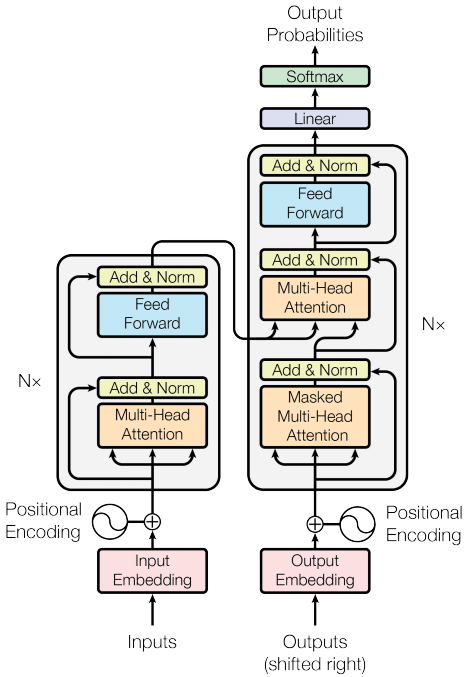

Ta có thể thấy lớp Encoder gồm N khối (ta tạm gọi là EncoderLayer). Và đầu ra của N khối này sẽ được nối sang bên Decoder. Tương tự với đó là bên Decoder cũng chứa N khối DecoderLayer. 

### Encoder:
- Gồm lớp Embedding, Positional Encoding và các lớp Encoder 
## Lớp Encoder:
- Gồm lớp Multi-Head Attention, 2 lớp Add & Norm và 1 mạng Feed Forward

### Decoder:
- Gồm lớp Embedding, Positional Encoding và các lớp Decoder 
## Lớp Encoder:
- Gồm lớp 3 khối:
 + Masked Multi-Head Attention, 1 lớp Add & Norm 
 + Multi-Head Attention nhận 2 ma trận K,V từ lớp encoder, 1 lớp Add & Norm 
 + 1 mạng Feed Forward và 1 lớp Add & Norm 
 
### Đi qua một mạng Linear và Softmax để có được output

# Model Defination

## Attension

In [28]:
def scaled_dot_product_attention(query, key, value, mask):
  """Calculate the attention weights. """
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # scale matmul_qk
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # add the mask to zero out padding tokens
  if mask is not None:
    logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  output = tf.matmul(attention_weights, value)

  return output

In [29]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # scaled dot-product attention
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # concatenation of heads
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs

### Masking

In [30]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [31]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

## Positional Encoding

In [32]:
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # apply sin to even index in the array
    sines = tf.math.sin(angle_rads[:, 0::2])
    # apply cos to odd index in the array
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

## Encoder Layer

In [33]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

## Encoder

In [34]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  embeddings = tf.keras.layers.Embedding(vocab_size,d_model
                                     ,input_length=maxlen_questions
                                     ,weights = [embedding_matrix]
                                     ,trainable=False)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

## Decoder Layer

In [35]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

## Decoder

In [36]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  

  embeddings = tf.keras.layers.Embedding(vocab_size,d_model
                                     ,input_length=maxlen_answers
                                     ,weights = [embedding_matrix]
                                     ,trainable=False)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

## Transformer

In [37]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)
  # mask the future tokens for decoder inputs at the 1st attention block
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)
  # mask the encoder outputs for the 2nd attention block
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  outputs = tf.keras.layers.Dense(units=vocab_size)(dec_outputs)
  #Add a softmax layer to get probability distribution of word in vocab
  outputs = tf.keras.layers.Dense(units=vocab_size, activation = 'softmax',name = "outputs")(outputs)


  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [38]:
tf.keras.backend.clear_session()

# Hyper-parameters
NUM_LAYERS = 2
NUM_HEADS = 6 # model dims must divided to number of heads
UNITS = 512
DROPOUT = 0.1

In [46]:
# Define the model
# VOCAB_SIZE = 3827
# embeddings_dim = 300
model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=embeddings_dim,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

In [47]:
model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, None)]               0         []                            
                                                                                                  
 dec_inputs (InputLayer)     [(None, None)]               0         []                            
                                                                                                  
 enc_padding_mask (Lambda)   (None, 1, 1, None)           0         ['inputs[0][0]']              
                                                                                                  
 encoder (Functional)        (None, None, 300)            2488924   ['inputs[0][0]',              
                                                                     'enc_padding_mask[0

## Define Loss Function

In [164]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, maxlen_answers))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

## Optimizer with custom learning rate

In [165]:
# class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

#   def __init__(self, d_model, warmup_steps=2000):
#     super(CustomSchedule, self).__init__()

#     self.d_model = d_model
#     self.d_model = tf.cast(self.d_model, tf.float32)

#     self.warmup_steps = warmup_steps

#   def __call__(self, step):
#     arg1 = tf.math.rsqrt(step)
#     arg2 = step * (self.warmup_steps**-1.5)

#     return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=2000):
        super(CustomSchedule, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)  # Cast d_model to float32
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)  # Cast step to float32
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


In [166]:
learning_rate = CustomSchedule(embeddings_dim)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


## Compile the model

In [167]:
def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, maxlen_answers))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

In [168]:
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [169]:
# Training the model
history = model.fit([encoder_input_data , decoder_input_data], decoder_output_data, batch_size=64, epochs=1000)

Epoch 1/5


2023-10-03 14:41:17.720519: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f373817efa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-03 14:41:17.720547: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-10-03 14:41:17.725198: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-03 14:41:17.885173: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8903
2023-10-03 14:41:17.980124: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


93/93 [==============================] - 25s 112ms/step - loss: 0.5647 - accuracy: 0.0179
Epoch 2/5
93/93 [==============================] - 10s 113ms/step - loss: 0.4519 - accuracy: 0.0238
Epoch 3/5
93/93 [==============================] - 11s 114ms/step - loss: 0.4140 - accuracy: 0.0252
Epoch 4/5
93/93 [==============================] - 11s 115ms/step - loss: 0.3755 - accuracy: 0.0263
Epoch 5/5
93/93 [==============================] - 11s 116ms/step - loss: 0.3430 - accuracy: 0.0273


## Visualize Training Progress

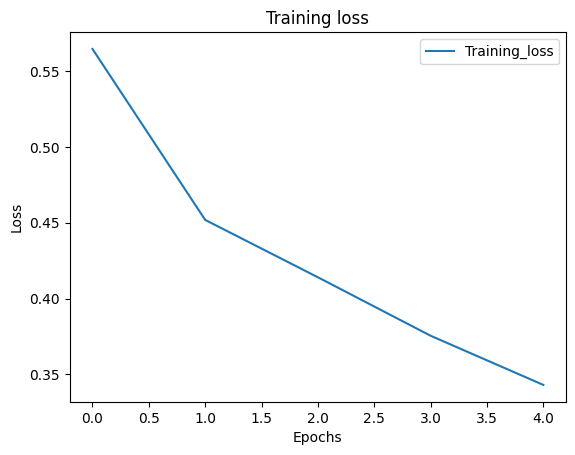

<Figure size 640x480 with 0 Axes>

In [172]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],label='Training_loss')
plt.legend()
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
plt.savefig('Loss_Graph')

In [173]:
model.save_weights('chatbot_weights.h5')

## Bot Chatting

In [48]:
model.load_weights('/home/dattran/datadrive/AI-project/vietnamese_chatbot_research/checkpoints/checkpoint_6362.h5')

# Check the loaded model architecture
model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, None)]               0         []                            
                                                                                                  
 dec_inputs (InputLayer)     [(None, None)]               0         []                            
                                                                                                  
 enc_padding_mask (Lambda)   (None, 1, 1, None)           0         ['inputs[0][0]']              
                                                                                                  
 encoder (Functional)        (None, None, 300)            2488924   ['inputs[0][0]',              
                                                                     'enc_padding_mask[0

In [49]:
idx2word = tokenizer.index_word

In [50]:
def str_to_tokens(sentence):
    words = word_tokenize(sentence.lower())
    tokens_list = []
    
    for word in words:
        tokens_list.append(word2idx[word]) 
    return pad_sequences([tokens_list],maxlen = maxlen_questions , padding='post')

In [51]:
def evaluate(sentence):
  sentence = str_to_tokens(sentence)
  output = np.zeros((1, 1))
  output[0, 0] = word2idx['start']

  for i in range(maxlen_answers):
    predictions = model(inputs=[sentence, output], training=False)

    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # return the result if the predicted_id is equal to the end token
    if tf.equal(predicted_id, word2idx['end']):
      break

    # concatenated the predicted_id to the output which is given to the decoder as its input.
    output = tf.concat([output, predicted_id], axis=-1)
    
  return tf.squeeze(output, axis=0)

def predict(sentence):
  prediction = evaluate(sentence)
  predicted_sentence = " ".join(idx2word[tf.get_static_value(i)] for i in prediction if i < VOCAB_SIZE)
  return predicted_sentence.replace("start","")

In [52]:
flag=True
print("BOT: Xin chào! Tôi là ChatBot. Nếu bạn muốn ngưng cuộc trò chuyện, hãy gõ Bye!")

while(flag==True):
    human_response = input('Enter question : ')
    if human_response != 'bye':
        try:
            print('BOT: ' + predict(human_response))
        except:
            print("BOT: Xin lỗi câu này tôi chưa đc học ,vui lòng hỏi lại :( ")
    else:
        flag=False
        print("BOT: Tạm biệt nha!")

BOT: Xin chào! Tôi là ChatBot. Nếu bạn muốn ngưng cuộc trò chuyện, hãy gõ Bye!


Enter question :  xin chào bạn tên là gì?


BOT: Xin lỗi câu này tôi chưa đc học ,vui lòng hỏi lại :( 


Enter question :  Thích mẫu người nào


BOT:  dễ thương tóc dài da trắng


Enter question :  Học trường nào?


BOT: Xin lỗi câu này tôi chưa đc học ,vui lòng hỏi lại :( 


Enter question :  Học ở đâu


BOT:  tdtu


Enter question :  Học lực ra sao


BOT:  khá giỏi nha


Enter question :  Học giỏi không


BOT:  không


Enter question :  Học ở đâu


BOT:  tdtu


Enter question :  Học ở đâu


BOT:  tdtu


Enter question :  Học ở đâu


BOT:  tdtu


Enter question :  bạn có Có kí túc xá không?


BOT: Xin lỗi câu này tôi chưa đc học ,vui lòng hỏi lại :( 


Enter question :  Có kí túc xá không


BOT:  có


Enter question :  có ở cùng với sinh viên trường không


BOT:  có cùng với 2 người trưuòng mình và 1 ở tài chính marketing


Enter question :  Bao nhiêu phòng ngủ


BOT:  3 phòng ngủ


Enter question :  nhà mày đâu?


BOT: Xin lỗi câu này tôi chưa đc học ,vui lòng hỏi lại :( 


Enter question :  nhà mày đâu


BOT:  tphcm


Enter question :  quê mày ở đâu 


BOT:  bình dương


Enter question :  quê tao ở bình thuận còn mày thì sao


BOT:  còn tao đi làm


Enter question :  quê tao ở đâu


BOT:  sài gòn


KeyboardInterrupt: Interrupted by user